In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import ctypes 
def qcatssim(orig:np.ndarray[np.float32], decompressed:np.ndarray[np.float32]):
    dims = np.array(orig.shape)[::-1]
    # print(dims)
    lib = ctypes.CDLL('/home/pji228/workspace/git/draft/artifact/compress_scripts/aramco_ssim/qcatssim_py.dylib')
    lib.calculateSSIM.restype = ctypes.c_double
    lib.calculateSSIM.argtypes = [np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.int32),
                              ctypes.c_int]
    result =lib.calculateSSIM(
        orig, 
        decompressed,
        dims.astype(np.int32), 
        ctypes.c_int(dims.size))
    return result 

In [2]:
orig = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32", dtype=np.float32).reshape(256,384,384)
decompressed = np.fromfile("/scratch/pji228/gittmp/posterization_mitigation/build/velocityx.f32.out", dtype=np.float32).reshape(256,384,384)
print(qcatssim(orig, decompressed)) 

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/pji228/gittmp/posterization_mitigation/build/velocityx.f32.out'

In [2]:
def verify(src_data, dec_data):
    """
    Compare the decompressed data with original data
    :param src_data: original data, numpy array
    :param dec_data: decompressed data, numpy array
    :return: max_diff, psnr, nrmse
    """
    data_range = np.max(src_data) - np.min(src_data)
    diff = src_data - dec_data
    max_diff = np.max(abs(diff))
    # print("abs err={:.8G}".format(max_diff))
    mse = np.mean(diff ** 2)
    nrmse = np.sqrt(mse) / data_range
    psnr = 20 * np.log10(data_range) - 10 * np.log10(mse)
    return  psnr

abs err=0.0045113191
abs err=0.007446019


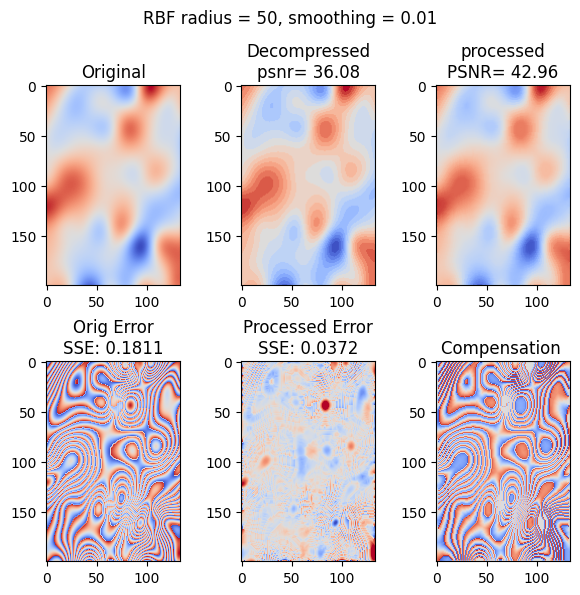

In [8]:
# 2d example 
orig = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/local_data_200x150.bin", dtype=np.float32).reshape(200,134)
# dec = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/local_dec_200x150.bin", dtype=np.float32).reshape(200,134)
dec = np.fromfile("../build//local_dec_200x150.bin", dtype=np.float32).reshape(200,134)

processed = np.fromfile("../build/local_data_200x150.bin_compensated_data.f32", dtype=np.float32).reshape(200,134)

orig_error = orig-dec
processed_error = orig-processed
error_compensation = processed - dec
figs, axs = plt.subplots(2, 3, figsize=(6,6))
v_max = orig.max()
v_min = orig.min()
axs[0,0].imshow(orig, cmap='coolwarm')
axs[0,0].set_title("Original")
axs[0,1].imshow(dec, cmap='coolwarm', vmin=v_min, vmax=v_max)
axs[0,1].set_title(f"Decompressed\npsnr= %.2f"%verify(orig, dec))
axs[0,2].imshow(processed, cmap='coolwarm', vmin=v_min, vmax=v_max)
axs[0,2].set_title(f"processed\nPSNR= %.2f"%verify(orig, processed))  
e_max = orig_error.max()
e_min = orig_error.min()
axs[1,0].imshow(orig_error, cmap='coolwarm', vmin=e_min, vmax=e_max)
axs[1,0].set_title(f"Orig Error\nSSE: %.4f" % np.sum(orig_error**2))
axs[1,1].imshow(processed_error, cmap='coolwarm', vmin=e_min, vmax=e_max)
axs[1,1].set_title(f"Processed Error\nSSE: %.4f" % np.sum(processed_error**2))
axs[1,2].imshow(error_compensation, cmap='coolwarm', vmin=e_min, vmax=e_max)
axs[1,2].set_title("Compensation ")
figs.suptitle('RBF radius = 50, smoothing = 0.01')
plt.tight_layout()
plt.show()


In [5]:
# from numba import njit
# @njit
def central_difference_gradient(map_3d, dx=1, dy=1, dz=1):
    grad_x = np.zeros_like(map_3d).astype(np.float32)
    grad_y = np.zeros_like(map_3d).astype(np.float32)
    grad_z = np.zeros_like(map_3d).astype(np.float32)
    
    # Calculate gradient using central difference
    grad_x[1:-1,:,:] = np.abs((map_3d[2:,:,:] - map_3d[:-2,:,:]) / (2 * dx))
    grad_y[:,1:-1,:] = np.abs((map_3d[:,2:,:] - map_3d[:,:-2,:]) / (2 * dy))
    grad_z[:,:,1:-1] = np.abs((map_3d[:,:,2:] - map_3d[:,:,:-2]) / (2 * dz))
    
    return grad_x, grad_y, grad_z

# @njit
def get_gradient_map(map_2d):
    grad_x, grad_y,grad_z  = central_difference_gradient(map_2d)
    grad_x = np.abs(grad_x)
    grad_y = np.abs(grad_y)
    grad_z = np.abs(grad_z)
    # agggrad will be the maximum gradient in the 3 directions \
    agg_grad = grad_x
    agg_grad = np.maximum(agg_grad, grad_y)
    agg_grad = np.maximum(agg_grad, grad_z)
    
    # grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)
    grad_direction = None
    return grad_x, grad_y , grad_z, agg_grad, grad_direction

In [3]:
boundary = np.fromfile("../build/boundary.int8", dtype=np.int8).reshape(256,384,384)

abs err=0.0045114979
abs err=0.0084334314
0.003981471
-0.0039848685


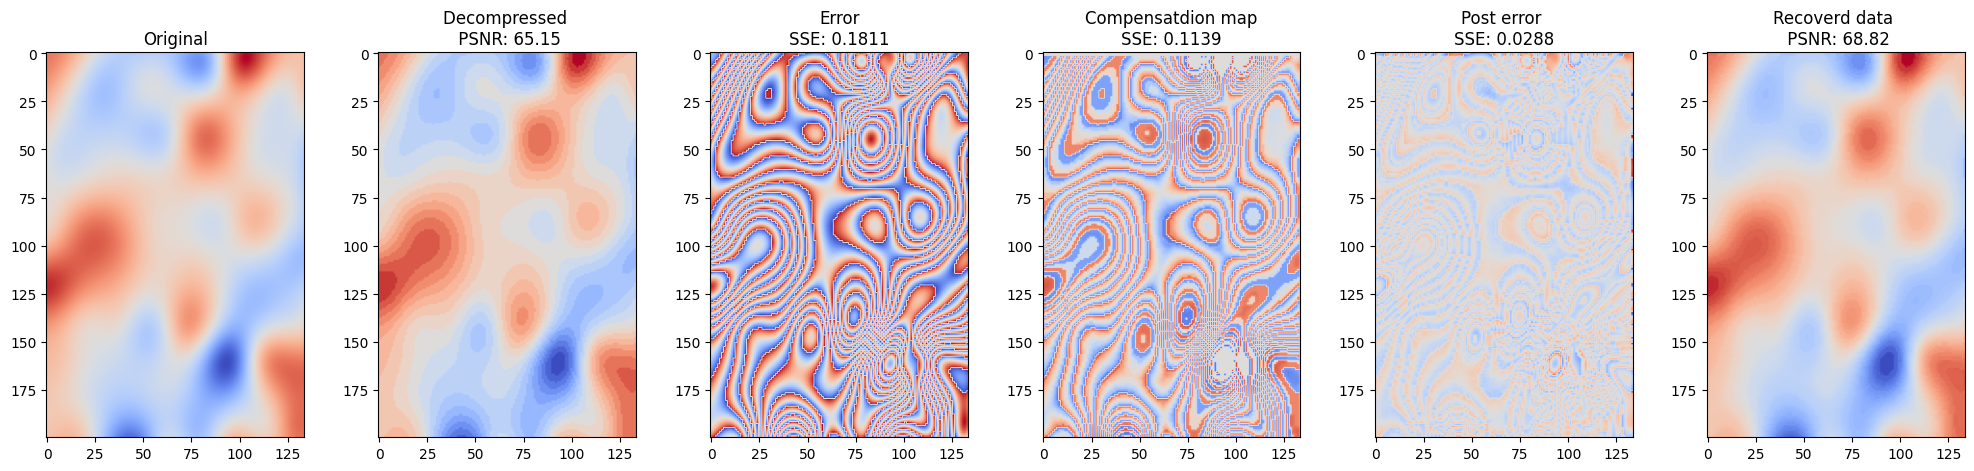

In [7]:
# comp = np.fromfile("../build/compensation_map_miranda_vx2.f32",dtype=np.float32).reshape(256,384,384)
odata = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32",dtype=np.float32).reshape(256,384,384)
ddata = np.fromfile("../build/velocityx.f32.dec",dtype=np.float32).reshape(256,384,384) 
qindex = np.fromfile("../build/quant_index.i32",dtype=np.int32).reshape(256,384,384)
error = odata - ddata
compensated_data = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32",dtype=np.float32).reshape(256,384,384)
# sign_map = np.fromfile("../build/sign.int8",dtype=np.int32).reshape(256,384,384) 

# d1 = np.fromfile("../build/distance1.f32",dtype=np.float64).reshape(256,384,384)
# d2 = np.fromfile("../build/distance2.f32",dtype=np.float64).reshape(256,384,384) 
# boundary = np.fromfile("../build/boundary.int8",dtype=np.int8).reshape(256,384,384)
# boundary2 = np.fromfile("../build/boundary2.int8",dtype=np.int8).reshape(256,384,384) 
# boundary2 = np.where(boundary2 == 1, 0, 1) 

# comp = (odata - compensated_data)+ error
# comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256,384,384)
comp = ( compensated_data - ddata)
post_error =  odata - compensated_data 
figs, axs = plt.subplots(1,6,figsize=(25,5))
x_slice = 81
x1 = 100
x2 = 300
y1 = 100
y2 = 300
# x1  =0 
# x2 = 50
# y1 = 250
# y2 = 300 

x1  =0 
x2 = 200 
y1 = 250
y2 = 400

# x1  =0+25
# x2 = x1+30 
# y1 = 250+20
# y2 = y1+ 30  

e_max = error[x_slice,x1:x2,y1:y2].max() 
# e_min = error[x_slice,x1:x2,y1:y2].min()
e_min = -e_max

axs[0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[0].set_title("Original")
axs[1].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[1].set_title("Decompressed \n PSNR: %.2f" % verify(odata, ddata))
axs[2].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[2].set_title("Error\nSSE: %.4f" % np.sum(error[x_slice,x1:x2,y1:y2]**2))
axs[3].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[3].set_title("Compensatdion map\nSSE: %.4f" % np.sum(comp[x_slice,x1:x2,y1:y2]**2))
axs[4].imshow(post_error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[4].set_title("Post error \nSSE: %.4f" % np.sum(post_error[x_slice,x1:x2,y1:y2]**2))

axs[5].imshow(compensated_data[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[5].set_title("Recoverd data \n PSNR: %.2f" % verify(odata, compensated_data))
# axs[4].imshow(compensated_data[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].set_title("Compensated")
# axs[4].imshow(sign_map[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].set_title("Sign")
# im = axs[4].imshow(d1[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=0, vmax=3)
# axs[4].set_title("Distance 1")
# plt.colorbar(im, ax=axs[4])

# axs[4].imshow(boundary[x_slice,x1:x2,y1:y2]*(-1)+ boundary2[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].set_title("Boundary")

# d_val = d2/(d1+d2)
# axs[5].imshow(d_val[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=0, vmax=3)
# axs[5].set_title("D_val")
# axs[4].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].set_title("boundary")
# axs[5].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[5].set_title("boundary")
# axs[4].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[4].set_title("Distance 1")
# axs[5].imshow(boundary2[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
# axs[5].set_title("Distance 2")
print(comp.max())
print(comp.min())

In [117]:
grad_x, grad_y , grad_z, grad_magnitude, grad_direction = get_gradient_map(qindex)

In [118]:
x_slice = 81

x1  =0+25
x2 = x1+30 
y1 = 250+90
y2 = y1+ 3  


print(grad_x[ x_slice, x1+10, y1+5:y1+15])
print(grad_y[ x_slice, x1+10, y1+5:y1+15])
print(grad_z[ x_slice, x1+10, y1+5:y1+15])
print(boundary[x_slice, x1+10, y1+5:y1+15])
print(comp[x_slice, x1+10, y1+5:y1+15])

[0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
[0.5 0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
[0.5 0.5 0.  0.  0.5 0.5 0.  0.  0.5 0.5]
[1 1 0 0 1 1 0 0 1 1]
[-0.00304526  0.00304526  0.00101509 -0.00101509 -0.00304526  0.00304526
  0.00101509 -0.00101509 -0.00304526  0.00304526]


In [7]:
odata = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32",dtype=np.float32).reshape(256,384,384)
ddata = np.fromfile("../build/velocityx.f32.dec",dtype=np.float32).reshape(256,384,384) 
post_data_d1 = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32.dir1.f32",dtype=np.float32).reshape(256,384,384) 
post_data_d2 = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32.dir2.f32",dtype=np.float32).reshape(256,384,384)
post_data_d3 = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32.dir3.f32",dtype=np.float32).reshape(256,384,384) 
# post_avg = (post_data_d1 + post_data_d2 + post_data_d3)/3 
post_avg = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32",dtype=np.float32).reshape(256,384,384)
post_3d = np.fromfile("../build/velocityx.f32.dec.compensated_data.f32.dir3d.f32",dtype=np.float32).reshape(256,384,384)
# post_3d = (post_data_d1 + post_data_d2 + post_data_d3)/3 
error = odata - ddata 
e1 = odata - post_data_d1
e2 = odata - post_data_d2
e3 = odata - post_data_d3
e4 = odata - post_avg 
e3d = odata - post_3d
c1 = post_data_d1 - ddata 
c2 = post_data_d2 - ddata
c3 = post_data_d3 - ddata
c4 = post_avg - ddata
c3d = post_3d - ddata 

print("PSNR d1: %.2f" % verify(odata, post_data_d1))
print("PSNR d2: %.2f" % verify(odata, post_data_d2))
print("PSNR d3: %.2f" % verify(odata, post_data_d3))
print("PSNR 6D: %.2f" % verify(odata, post_avg))
print("PSNR 3d: %.2f" % verify(odata, post_3d))


PSNR d1: 67.48
PSNR d2: 68.81
PSNR d3: 68.34
PSNR 6D: 69.17
PSNR 3d: 69.06


Text(0.5, 1.0, '3D PSNR= 44.88')

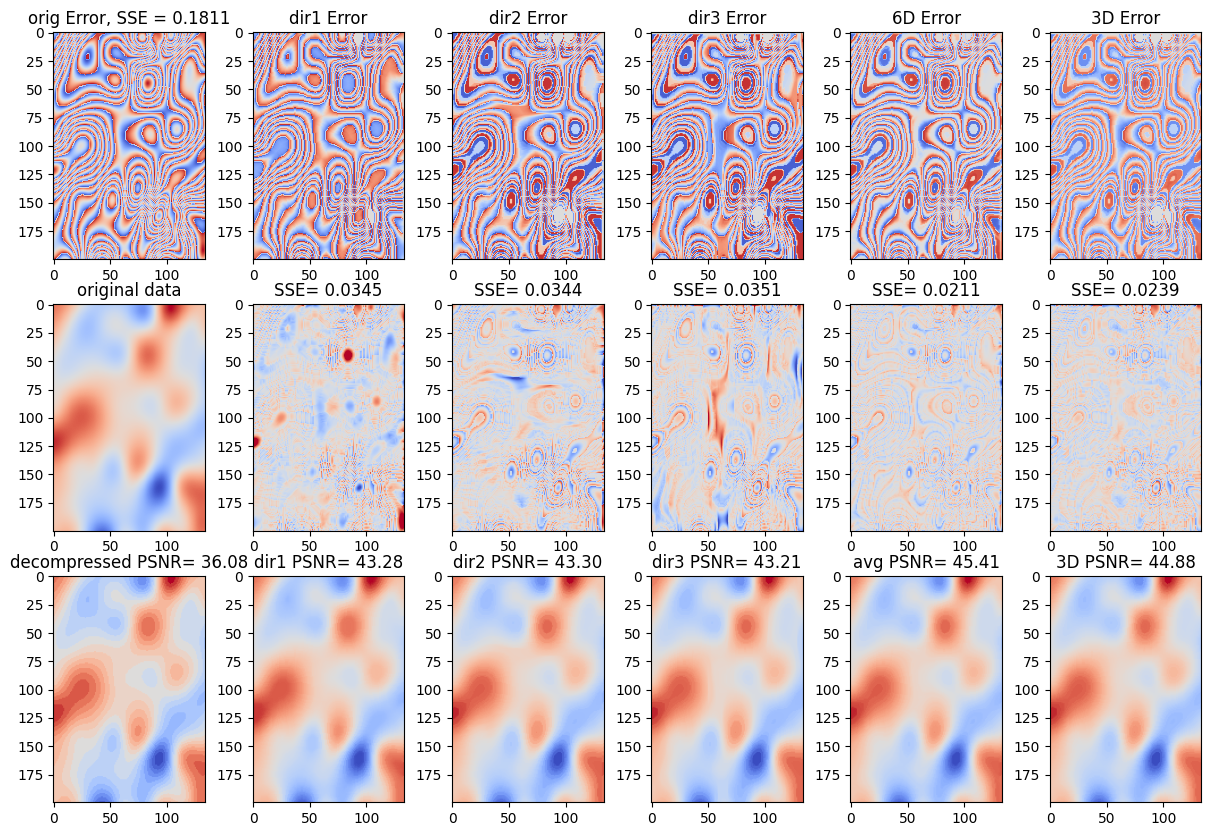

In [8]:
x_slice = 81
x1  =0 
x2 = 200 
y1 = 250
y2 = 400
e_max = error[x_slice,x1:x2,y1:y2].max()
e_min = -e_max
figs, axs = plt.subplots(3,6,figsize=(15,10))

axs[0,0].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,0].set_title("orig Error, SSE = %.4f" % np.sum(error[x_slice,x1:x2,y1:y2]**2))
axs[0,1].imshow(c1[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,1].set_title("dir1 Error")
axs[0,2].imshow(c2[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,2].set_title("dir2 Error")
axs[0,3].imshow(c3[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,3].set_title("dir3 Error")
axs[0,4].imshow(c4[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,4].set_title("6D Error")
axs[0,5].imshow(c3d[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,5].set_title("3D Error")

axs[1,0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[1,0].set_title("original data")
axs[1,1].imshow(e1[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,1].set_title("SSE= %.4f" % np.sum(e1[x_slice,x1:x2,y1:y2]**2))
axs[1,2].imshow(e2[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,2].set_title("SSE= %.4f" % np.sum(e2[x_slice,x1:x2,y1:y2]**2))
axs[1,3].imshow(e3[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,3].set_title("SSE= %.4f" % np.sum(e3[x_slice,x1:x2,y1:y2]**2))
axs[1,4].imshow(e4[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,4].set_title("SSE= %.4f" % np.sum(e4[x_slice,x1:x2,y1:y2]**2))
axs[1,5].imshow(e3d[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,5].set_title("SSE= %.4f" % np.sum(e3d[x_slice,x1:x2,y1:y2]**2))

axs[2,0].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,0].set_title("decompressed PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], ddata[x_slice,x1:x2,y1:y2]))
axs[2,1].imshow(post_data_d1[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,1].set_title("dir1 PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], post_data_d1[x_slice,x1:x2,y1:y2]))
axs[2,2].imshow(post_data_d2[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,2].set_title("dir2 PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], post_data_d2[x_slice,x1:x2,y1:y2]))
axs[2,3].imshow(post_data_d3[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,3].set_title("dir3 PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], post_data_d3[x_slice,x1:x2,y1:y2]))
axs[2,4].imshow(post_avg[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,4].set_title("avg PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], post_avg[x_slice,x1:x2,y1:y2]))
axs[2,5].imshow(post_3d[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2,5].set_title("3D PSNR= %.2f" % verify(odata[x_slice,x1:x2,y1:y2], post_3d[x_slice,x1:x2,y1:y2]))


# d1, d2, d3 


Text(0.5, 1.0, '3D PSNR= 62.87')

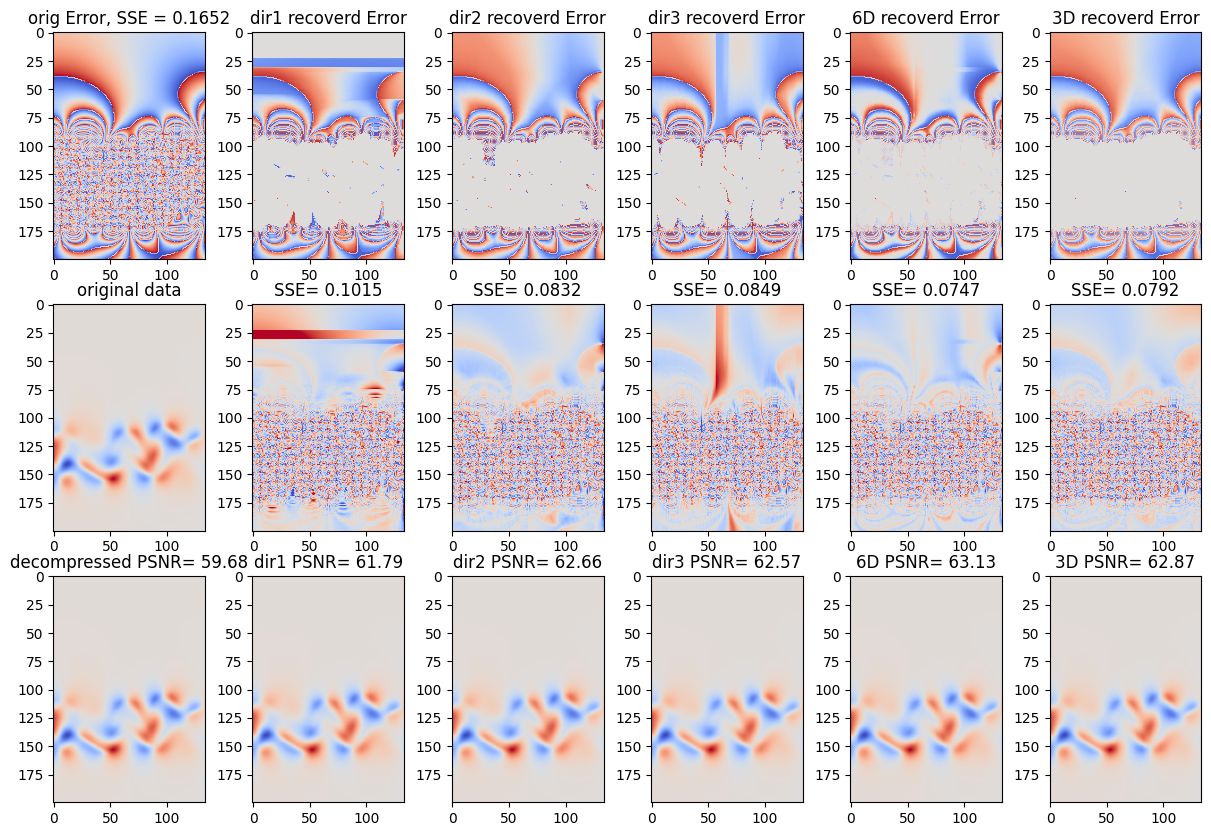

In [9]:
x_slice = 81
x1  =0 
x2 = 200 
y1 = 250
y2 = 400
e_max = error[x1:x2, x_slice, y1:y2].max()
e_min = -e_max
figs, axs = plt.subplots(3,6,figsize=(15,10))

axs[0,0].imshow(error[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,0].set_title("orig Error, SSE = %.4f" % np.sum(error[x1:x2, x_slice, y1:y2]**2))
axs[0,1].imshow(c1[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,1].set_title("dir1 recoverd Error")
axs[0,2].imshow(c2[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,2].set_title("dir2 recoverd Error")
axs[0,3].imshow(c3[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,3].set_title("dir3 recoverd Error")
axs[0,4].imshow(c4[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,4].set_title("6D recoverd Error")
axs[0,5].imshow(c3d[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,5].set_title("3D recoverd Error")

axs[1,0].imshow(odata[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[1,0].set_title("original data")
axs[1,1].imshow(e1[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,1].set_title("SSE= %.4f" % np.sum(e1[x1:x2, x_slice, y1:y2]**2))
axs[1,2].imshow(e2[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,2].set_title("SSE= %.4f" % np.sum(e2[x1:x2, x_slice, y1:y2]**2))
axs[1,3].imshow(e3[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,3].set_title("SSE= %.4f" % np.sum(e3[x1:x2, x_slice, y1:y2]**2))
axs[1,4].imshow(e4[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,4].set_title("SSE= %.4f" % np.sum(e4[x1:x2, x_slice, y1:y2]**2))
axs[1,5].imshow(e3d[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,5].set_title("SSE= %.4f" % np.sum(e3d[x1:x2, x_slice, y1:y2]**2))
axs[2,0].imshow(ddata[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,0].set_title("decompressed PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], ddata[x1:x2, x_slice, y1:y2]))
axs[2,1].imshow(post_data_d1[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,1].set_title("dir1 PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], post_data_d1[x1:x2, x_slice, y1:y2]))
axs[2,2].imshow(post_data_d2[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,2].set_title("dir2 PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], post_data_d2[x1:x2, x_slice, y1:y2]))
axs[2,3].imshow(post_data_d3[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,3].set_title("dir3 PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], post_data_d3[x1:x2, x_slice, y1:y2]))
axs[2,4].imshow(post_avg[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,4].set_title("6D PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], post_avg[x1:x2, x_slice, y1:y2]))
axs[2,5].imshow(post_3d[x1:x2, x_slice, y1:y2], cmap='coolwarm', interpolation=None)
axs[2,5].set_title("3D PSNR= %.2f" % verify(odata[x1:x2, x_slice, y1:y2], post_3d[x1:x2, x_slice, y1:y2]))


Text(0.5, 1.0, '3D PSNR= 69.06')

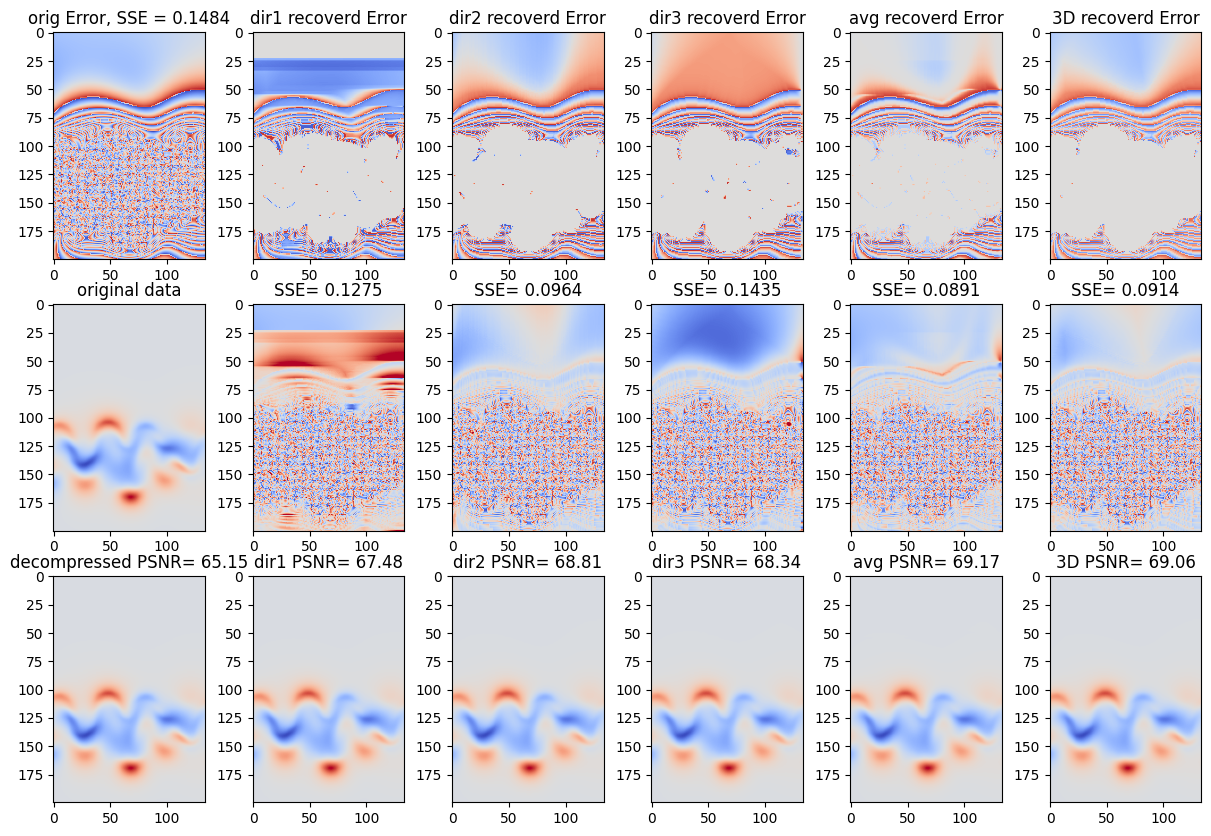

In [10]:
x_slice = 81
x1  =0 
x2 = 200 
y1 = 250
y2 = 400
e_max = error[x1:x2, y1:y2, x_slice].max()
e_min = -e_max
figs, axs = plt.subplots(3,6,figsize=(15,10))

axs[0,0].imshow(error[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,0].set_title("orig Error, SSE = %.4f" % np.sum(error[x1:x2, y1:y2, x_slice]**2))
axs[0,1].imshow(c1[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,1].set_title("dir1 recoverd Error")
axs[0,2].imshow(c2[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,2].set_title("dir2 recoverd Error")
axs[0,3].imshow(c3[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,3].set_title("dir3 recoverd Error")
axs[0,4].imshow(c4[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,4].set_title("avg recoverd Error")
axs[0,5].imshow(c3d[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[0,5].set_title("3D recoverd Error")

axs[1,0].imshow(odata[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[1,0].set_title("original data")
axs[1,1].imshow(e1[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,1].set_title("SSE= %.4f" % np.sum(e1[x1:x2, y1:y2, x_slice]**2))
axs[1,2].imshow(e2[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,2].set_title("SSE= %.4f" % np.sum(e2[x1:x2, y1:y2, x_slice]**2))
axs[1,3].imshow(e3[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,3].set_title("SSE= %.4f" % np.sum(e3[x1:x2, y1:y2, x_slice]**2))
axs[1,4].imshow(e4[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,4].set_title("SSE= %.4f" % np.sum(e4[x1:x2, y1:y2, x_slice]**2))
axs[1,5].imshow(e3d[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None, vmin=e_min, vmax=e_max)
axs[1,5].set_title("SSE= %.4f" % np.sum(e3d[x1:x2, y1:y2, x_slice]**2))
axs[2,0].imshow(ddata[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,0].set_title("decompressed PSNR= %.2f" % verify(odata, ddata))
axs[2,1].imshow(post_data_d1[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,1].set_title("dir1 PSNR= %.2f" % verify(odata, post_data_d1))
axs[2,2].imshow(post_data_d2[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,2].set_title("dir2 PSNR= %.2f" % verify(odata, post_data_d2))
axs[2,3].imshow(post_data_d3[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,3].set_title("dir3 PSNR= %.2f" % verify(odata, post_data_d3))
axs[2,4].imshow(post_avg[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,4].set_title("avg PSNR= %.2f" % verify(odata, post_avg))
axs[2,5].imshow(post_3d[x1:x2, y1:y2, x_slice], cmap='coolwarm', interpolation=None)
axs[2,5].set_title("3D PSNR= %.2f" % verify(odata, post_3d))


In [20]:
odata_t = odata.transpose(2,1,0)
odata_t.astype(np.float32).tofile("velocityx_384x384x256.f32")

Text(0.5, 1.0, 'Recovered error')

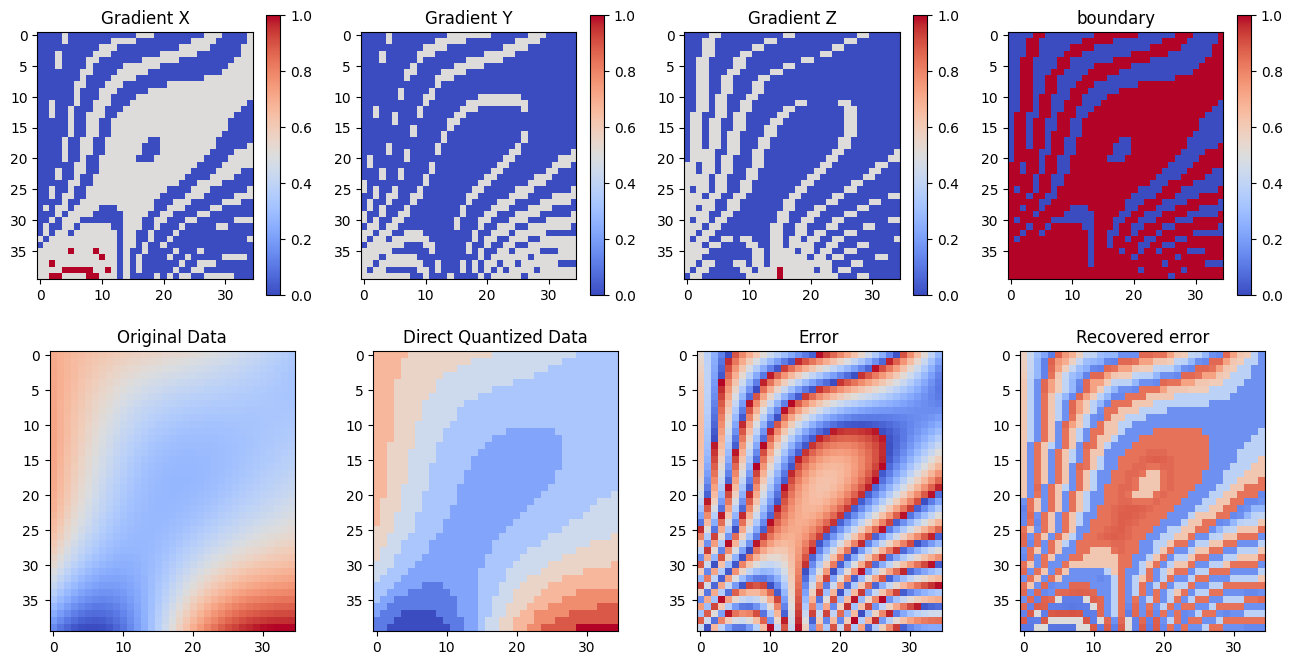

In [119]:
x_slice = 81

x1  =0+110 
x2 = 0+150  
y1 = 250+90 
y2 = 250+125 


figs, axs = plt.subplots(2,4,figsize=(16,8))
im = axs[0,0].imshow(grad_x[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,0].set_title("Gradient X")
plt.colorbar(im, ax=axs[0,0])   
im = axs[0,1].imshow(grad_y[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,1].set_title("Gradient Y")
plt.colorbar(im, ax=axs[0,1])
im = axs[0,2].imshow(grad_z[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,2].set_title("Gradient Z")
plt.colorbar(im, ax=axs[0,2])
# im = axs[0,2].imshow(grad_magnitude[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
# axs[0,2].set_title("Gradient Magnitude")
# plt.colorbar(im, ax=axs[0,2])

im = axs[0,3].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,3].set_title("boundary")
plt.colorbar(im, ax=axs[0,3])


axs[1,0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,0].set_title("Original Data")
axs[1,1].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,1].set_title("Direct Quantized Data")
emax = np.max(np.abs(error))

axs[1,2].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm',vmax=emax, vmin=-emax)
axs[1,2].set_title("Error")
axs[1,3].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=emax, vmin=-emax)
axs[1,3].set_title("Recovered error")


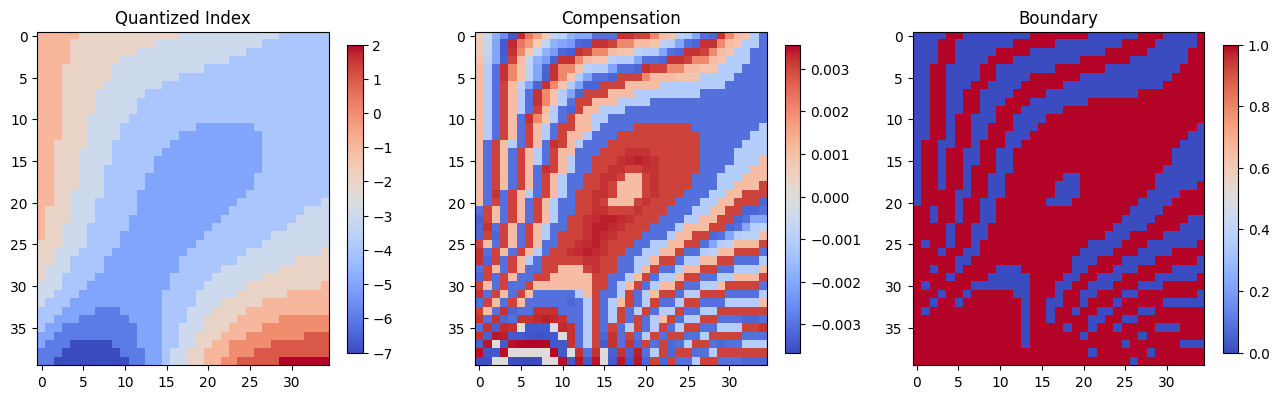

In [120]:
figs, axs = plt.subplots(1,3,figsize=(16,8)) 
im = axs[0].imshow(qindex[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.5)  
im = axs[1].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.5)
im = axs[2].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.5)

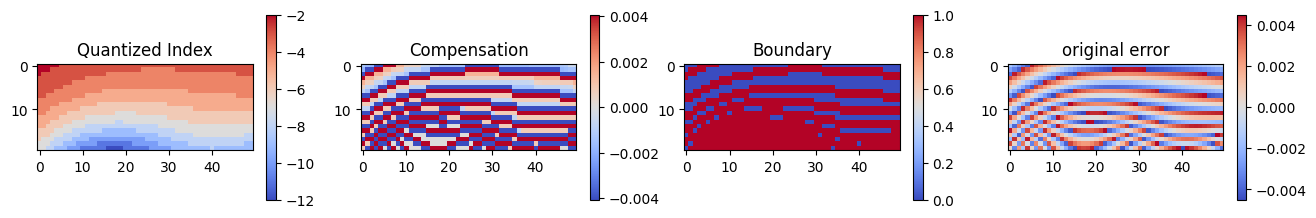

In [8]:
x_slice = 100+25 
y1 = 81-10
y2 = 81+10 
z1 = 100+50
z2 = 100+100 
figs, axs = plt.subplots(1,4,figsize=(16,8)) 
im = axs[0].imshow(qindex[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.3)  
im = axs[1].imshow(comp[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.3)
im = axs[2].imshow(boundary[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.3)
im = axs[3].imshow(error[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[3].set_title("original error")
plt.colorbar(im, ax=axs[3],shrink=0.3)

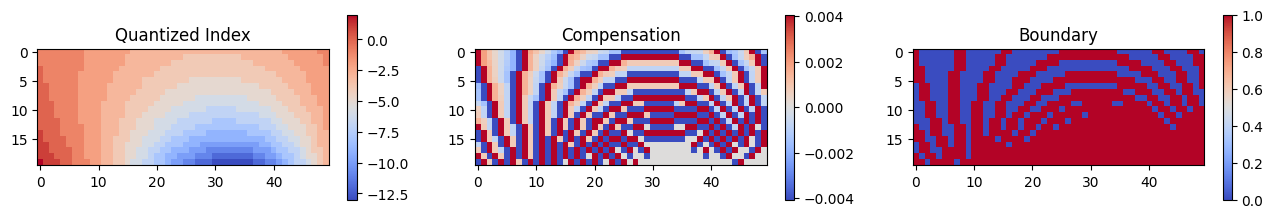

In [23]:
x_slice = 175 
y1 = 81-10
y2 = 81+10 
z1 = 100
z2 = 150 
figs, axs = plt.subplots(1,3,figsize=(16,8)) 
im = axs[0].imshow(qindex[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.3)  
im = axs[1].imshow(comp[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.3)
im = axs[2].imshow(boundary[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.3)

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


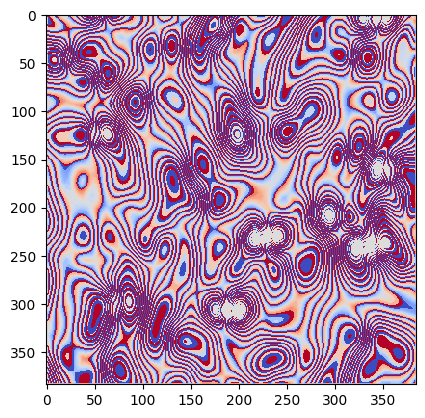

In [8]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


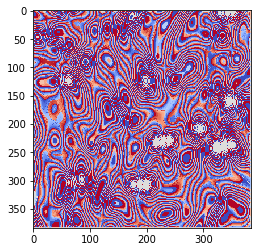

In [3]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

0.3890205
-0.3890205
(array([ 45216709,  45216710,  45217060, ..., 295395691, 295396043,
       295396395]),)


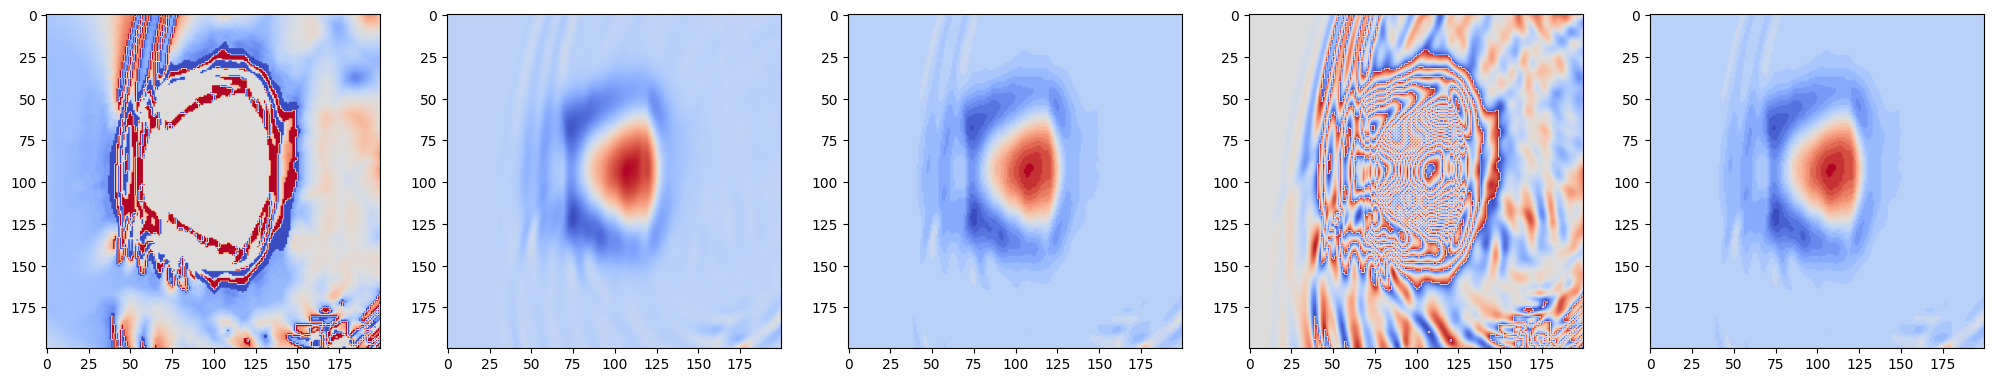

In [20]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(1008,1008,352)
odata = np.fromfile("/project/xli281_uksr/pjiao/data/aramco_1008x1008x352/pressure_2000.f32.dat",dtype=np.float32).reshape(1008,1008,352)
ddata = np.fromfile("../build/pressure_2000.f32.dat.out",dtype=np.float32).reshape(1008,1008,352) 
qindex = np.fromfile("../build/pressure_2000.f32.dat.quant.i32",dtype=np.int32).reshape(1008,1008,352)-2**15
error = odata - ddata
compensated_data = ddata + comp 
figs, axs = plt.subplots(1,5,figsize=(25,5))
x_slice = 219
x1 = 400
x2 = 600
y1 = 0
y2 = 200
axs[0].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[1].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[3].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[4].imshow(qindex[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

In [17]:
from numba import njit
@njit
def central_difference_gradient(map_3d, dx=1, dy=1, dz=1):
    grad_x = np.zeros_like(map_3d).astype(np.float32)
    grad_y = np.zeros_like(map_3d).astype(np.float32)
    grad_z = np.zeros_like(map_3d).astype(np.float32)
    
    # Calculate gradient using central difference
    grad_x[1:-1,:,:] = np.abs((map_3d[2:,:,:] - map_3d[:-2,:,:]) / (2 * dx))
    grad_y[:,1:-1,:] = np.abs((map_3d[:,2:,:] - map_3d[:,:-2,:]) / (2 * dy))
    grad_z[:,:,1:-1] = np.abs((map_3d[:,:,2:] - map_3d[:,:,:-2]) / (2 * dz))
    
    return grad_x, grad_y, grad_z

@njit
def get_gradient_map(map_2d):
    grad_x, grad_y,grad_z  = central_difference_gradient(map_2d)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)
    grad_direction = None
    return grad_x, grad_y , grad_z, grad_magnitude, grad_direction

In [21]:
grad_x, grad_y , grad_z, grad_magnitude, grad_direction = get_gradient_map(qindex)

Text(0.5, 1.0, 'Recovered error')

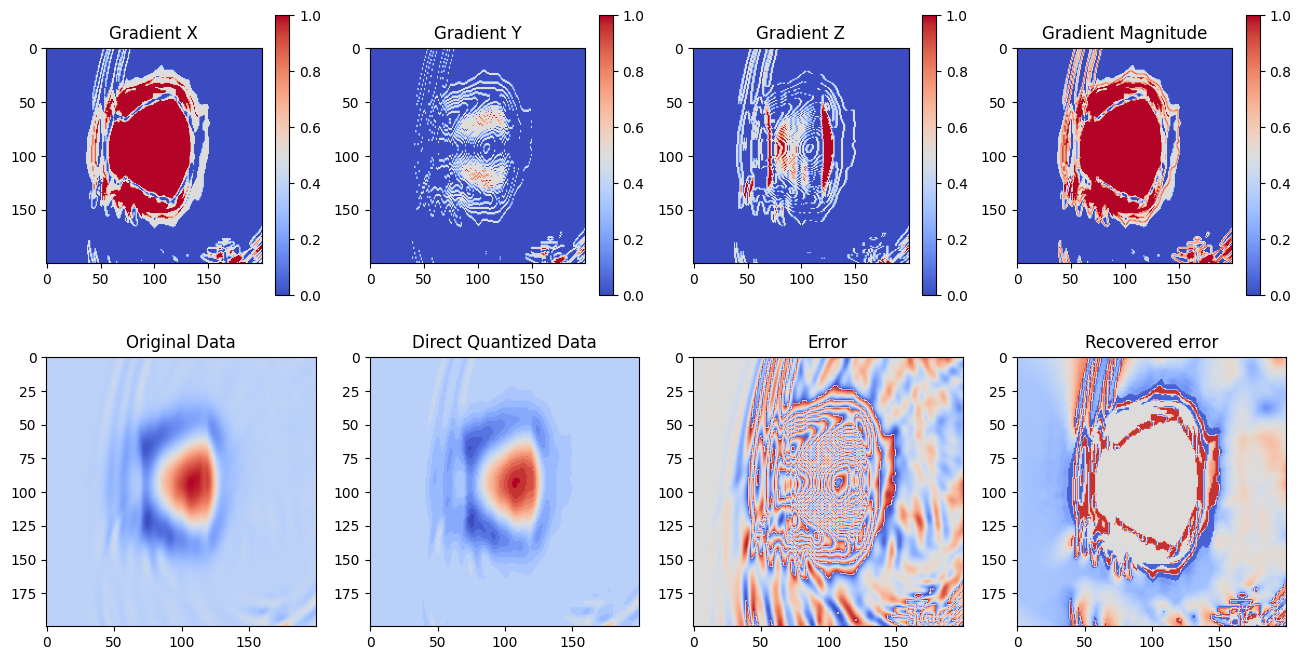

In [22]:
figs, axs = plt.subplots(2,4,figsize=(16,8))
im = axs[0,0].imshow(grad_x[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,0].set_title("Gradient X")
plt.colorbar(im, ax=axs[0,0])   
im = axs[0,1].imshow(grad_y[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,1].set_title("Gradient Y")
plt.colorbar(im, ax=axs[0,1])
im = axs[0,2].imshow(grad_z[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,2].set_title("Gradient Z")
plt.colorbar(im, ax=axs[0,2])
im = axs[0,3].imshow(grad_magnitude[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,3].set_title("Gradient Magnitude")
plt.colorbar(im, ax=axs[0,3])
axs[1,0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,0].set_title("Original Data")
axs[1,1].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,1].set_title("Direct Quantized Data")
emax = np.max(np.abs(error))

axs[1,2].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm',vmax=emax, vmin=-emax)
axs[1,2].set_title("Error")
axs[1,3].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=emax, vmin=-emax)
axs[1,3].set_title("Recovered error")


In [4]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256)
plt.imshow(comp[221], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

ValueError: cannot reshape array of size 357654528 into shape (256,)

In [ ]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape()
plt.imshow(comp[221], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

In [4]:
distance_array = np.fromfile("distance_array.f64",dtype=np.float64).reshape(200, 134) 
plt.imshow(distance_array, cmap='coolwarm', interpolation='nearest')

FileNotFoundError: [Errno 2] No such file or directory: 'distance_array.f64'

In [5]:
comp = np.fromfile("compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

FileNotFoundError: [Errno 2] No such file or directory: 'compensation_map.f32'

In [ ]:
import 